# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13232545.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

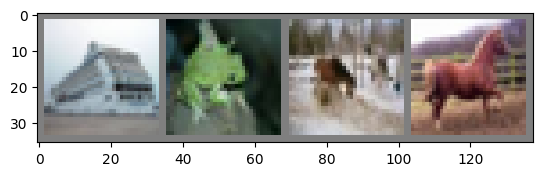

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32)
        )

        self.conv1x1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)

        self.out_block = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        out = self.input_block(x) + self.conv1x1(x)
        out = self.out_block(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (input_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (out_block): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [14]:
def test(model, criterion, test_loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            logits = model(data)
            loss = criterion(logits, target)

        loss_log.append(loss.item() * data.shape[0])
        
        acc = (logits.argmax(dim=1) == target).sum()
        acc_log.append(acc.item() / data.shape[0])  
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, criterion, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item() * data.shape[0])
        
        acc = (logits.argmax(dim=1) == target).sum()
        acc_log.append(acc.item() / data.shape[0])  

    return loss_log, acc_log

def train(model, optimizer, criterion, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader)
        val_loss, val_acc = test(model, criterion, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [15]:
n_epochs = 20

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net,
                                                                 optimizer, 
                                                                 criterion, 
                                                                 n_epochs, 
                                                                 train_loader, 
                                                                 val_loader)

Epoch 0
 train loss: 92.82704878637952, train acc: 0.4834935688169234
 val loss: 75.5393921101347, val acc: 0.5826462765957446

Epoch 1
 train loss: 72.53310208433943, train acc: 0.6031600940193262
 val loss: 71.39202705951448, val acc: 0.6189716312056737

Epoch 2
 train loss: 65.90655193206815, train acc: 0.6417023047793158
 val loss: 67.12285046475999, val acc: 0.638142730496454

Epoch 3
 train loss: 62.444924511464905, train acc: 0.6615589905980674
 val loss: 63.99171820092708, val acc: 0.6536347517730497

Epoch 4
 train loss: 60.50354692748521, train acc: 0.6712873792112823
 val loss: 63.89027692713636, val acc: 0.6537898936170212

Epoch 5
 train loss: 59.013831169993175, train acc: 0.6793753264559937
 val loss: 60.893363828861965, val acc: 0.6732491134751774

Epoch 6
 train loss: 57.271184576930686, train acc: 0.6891975711674067
 val loss: 66.37835934415777, val acc: 0.6511303191489362

Epoch 7
 train loss: 56.22707645897456, train acc: 0.6936536954818491
 val loss: 61.78600924065

Посчитайте точность на тестовой выборке:

In [21]:
test(net, criterion, test_loader)

(57.0634166085796, 0.6904856687898089)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [50]:
def plot_losses(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    val_step = len(train_acc_log) // n_epochs

    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(val_step, len(train_losses) + val_step, val_step), val_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(val_step,  len(train_accuracies) + val_step, val_step), val_accuracies, label='val')
    axs[1].set_ylabel('accuracy')


    for ax in axs:
        ax.set_xlabel('optimizer_step')
        ax.legend()

    plt.show()

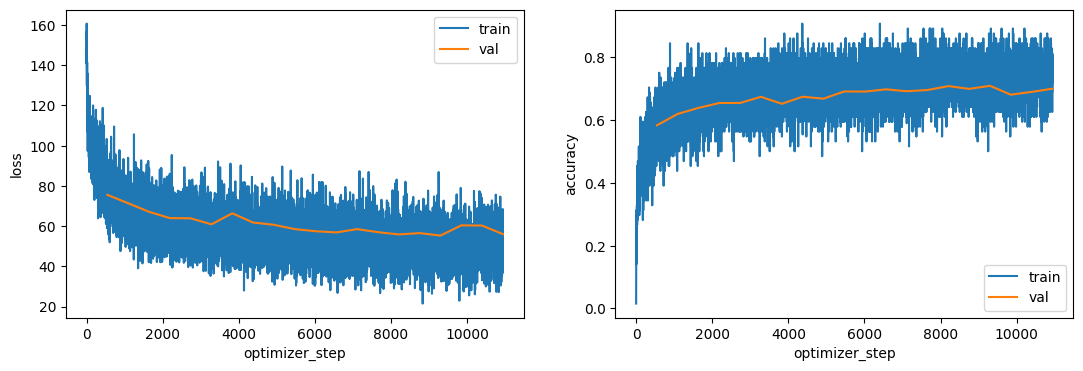

In [51]:
plot_losses(n_epochs, train_loss_log, val_loss_log, train_acc_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [52]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net,
                                                           optimizer,
                                                           criterion,
                                                           n_epochs,
                                                           train_loader,
                                                           val_loader,
                                                           scheduler)

Epoch 0
 train loss: 93.66474737589276, train acc: 0.4792904478976234
 val loss: 80.82333084674592, val acc: 0.5555629432624114

Epoch 1
 train loss: 73.2175393043532, train acc: 0.6006667863671976
 val loss: 73.96090319613192, val acc: 0.5969193262411349

Epoch 2
 train loss: 66.99446499107961, train acc: 0.6350711674066336
 val loss: 77.33126831866325, val acc: 0.586325354609929

Epoch 3
 train loss: 63.17124056249475, train acc: 0.6562418386001567
 val loss: 63.13795751612237, val acc: 0.6609929078014184

Epoch 4
 train loss: 60.528148572667206, train acc: 0.6710262144162966
 val loss: 64.14800746187251, val acc: 0.6513741134751774

Epoch 5
 train loss: 58.57574325069867, train acc: 0.6818808762078872
 val loss: 61.49465620568458, val acc: 0.6657801418439715

Epoch 6
 train loss: 57.421176767436414, train acc: 0.6858309937320449
 val loss: 59.35741451344592, val acc: 0.6829343971631204

Epoch 7
 train loss: 56.26333085013046, train acc: 0.6937271480804388
 val loss: 57.6423516740190

Посчитайте точность на тестовой выборке:

In [53]:
test(net, criterion, test_loader)

(53.079603419941705, 0.7174562101910829)

Качество на тестовой выборке повысилось

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [54]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net,
                                                           optimizer,
                                                           criterion,
                                                           n_epochs,
                                                           train_loader,
                                                           val_loader)

Epoch 0
 train loss: 118.9342514365857, train acc: 0.34674931444241314
 val loss: 104.55992768064458, val acc: 0.4318484042553192

Epoch 1
 train loss: 100.62431122572374, train acc: 0.44763645860538
 val loss: 94.97898217059196, val acc: 0.4780806737588653

Epoch 2
 train loss: 92.45652637098128, train acc: 0.49229563854792374
 val loss: 89.84138829657373, val acc: 0.5048315602836879

Epoch 3
 train loss: 87.06943841303071, train acc: 0.5224887372682162
 val loss: 83.8732255935669, val acc: 0.5406693262411347

Epoch 4
 train loss: 83.1540149343515, train acc: 0.5456263058239749
 val loss: 80.24779410260788, val acc: 0.5645833333333332

Epoch 5
 train loss: 79.70304286370984, train acc: 0.5636752415774353
 val loss: 77.52017570252114, val acc: 0.578302304964539

Epoch 6
 train loss: 77.08152416724391, train acc: 0.581499738835205
 val loss: 76.71660875361016, val acc: 0.5807624113475178

Epoch 7
 train loss: 74.24530564714394, train acc: 0.5959862235570645
 val loss: 74.08481391338591,

In [55]:
test(net, criterion, test_loader)

(59.73864242529414, 0.6754578025477707)

Качество на тестовый выборке при константном lr=0.001 стало хуже

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

[torch.optim.lr_scheduler.LambdaLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR) Устанавливает скорость обучения каждой группы параметров на начальное значение lr, умноженное на заданную функцию. Когда last_epoch=-1, устанавливает начальный lr как lr.

lr_epoch = lr_initial * Lambda(epoch)

In [57]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.65 ** epoch)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net,
                                                           optimizer,
                                                           criterion,
                                                           n_epochs,
                                                           train_loader,
                                                           val_loader,
                                                           scheduler)

Epoch 0
 train loss: 93.80461333133621, train acc: 0.4800943457821885
 val loss: 80.7732825948837, val acc: 0.5541445035460992

Epoch 1
 train loss: 71.70632679414487, train acc: 0.609901410289893
 val loss: 70.34756507061897, val acc: 0.6186613475177306

Epoch 2
 train loss: 64.02680393721111, train acc: 0.6518999738835205
 val loss: 63.495970792973296, val acc: 0.6542331560283688

Epoch 3
 train loss: 59.61662524709754, train acc: 0.6773186536954818
 val loss: 60.319222007913794, val acc: 0.6737810283687944

Epoch 4
 train loss: 57.050546833540444, train acc: 0.6908135283363802
 val loss: 59.307894311052685, val acc: 0.680895390070922

Epoch 5
 train loss: 55.18272170724119, train acc: 0.7022068425176287
 val loss: 57.95562492532933, val acc: 0.6865469858156029

Epoch 6
 train loss: 53.91192682046559, train acc: 0.7105722773570123
 val loss: 56.686201541981795, val acc: 0.6907801418439715

Epoch 7
 train loss: 52.88881366823883, train acc: 0.7164648080438757
 val loss: 56.17839050292

In [58]:
test(net, criterion, test_loader)

(55.32412949337321, 0.7007364649681529)

Качество на валидационной выборке хуже чем при MultiStepLR, но лучше чем вообще без scheduler

[torch.optim.lr_scheduler.ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)  Снижает скорость обучения каждой группы параметров по гамме каждую эпоху. Когда last_epoch=-1, устанавливает начальный lr как lr.

$$lr_{epoch} = 𝐺𝑎𝑚𝑚𝑎 * lr_{epoch - 1}$$
 


In [59]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net,
                                                           optimizer,
                                                           criterion,
                                                           n_epochs,
                                                           train_loader,
                                                           val_loader,
                                                           scheduler)

Epoch 0
 train loss: 95.37372497056477, train acc: 0.4675461935231131
 val loss: 78.13455966381316, val acc: 0.5728723404255319

Epoch 1
 train loss: 70.48611872985114, train acc: 0.6124028793418648
 val loss: 68.63219982309545, val acc: 0.625531914893617

Epoch 2
 train loss: 66.60392153982271, train acc: 0.6341530099242623
 val loss: 67.22338562417538, val acc: 0.6335992907801418

Epoch 3
 train loss: 66.10481765457655, train acc: 0.6390620919300078
 val loss: 67.15891683862564, val acc: 0.6332890070921987

Epoch 4
 train loss: 66.09559684348935, train acc: 0.6388662183337687
 val loss: 67.16369164243658, val acc: 0.6333998226950354

Epoch 5
 train loss: 66.07607232412865, train acc: 0.6405107404021938
 val loss: 67.1437810938409, val acc: 0.6327570921985817

Epoch 6
 train loss: 66.06753369877063, train acc: 0.6392538848263254
 val loss: 67.12697061579279, val acc: 0.6343971631205673

Epoch 7
 train loss: 66.1441609279765, train acc: 0.6367156894750587
 val loss: 67.13109709962886, 

In [60]:
test(net, criterion, test_loader)

(67.23277204355617, 0.6299761146496815)

Качество на валидационной выборке хуже чем при MultiStepLR и хуже чем вообще без scheduler

[torch.optim.lr_scheduler.CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR) Установливает скорость обучения каждой группы параметров, используя график косинусного отжига. Когда last_epoch=-1, устанавливает начальный lr как lr. Стоит отметить, что поскольку расписание определяется рекурсивно, скорость обучения может быть одновременно изменена вне этого планировщика другими операторами. Если скорость обучения устанавливается исключительно этим планировщиком, скорость обучения на каждом шаге становится:

$$ η_t=η_{min} + \frac{1}{2} * (η_{max} - η_{min})*(1 + cos(\frac{T_{cur}}{T_{max}} * π)) $$

Это было предложено в SGDR: Stochastic Gradient Descent with Warm Restarts. https://arxiv.org/abs/1608.03983

In [61]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net,
                                                           optimizer,
                                                           criterion,
                                                           n_epochs,
                                                           train_loader,
                                                           val_loader,
                                                           scheduler)

Epoch 0
 train loss: 97.05061498987173, train acc: 0.4580748890049621
 val loss: 85.11959074710278, val acc: 0.5260859929078014

Epoch 1
 train loss: 78.12049071923906, train acc: 0.5704002350483155
 val loss: 80.74711550042984, val acc: 0.5615913120567375

Epoch 2
 train loss: 70.13162809752023, train acc: 0.6166304844606947
 val loss: 71.29494339963223, val acc: 0.6125886524822695

Epoch 3
 train loss: 65.71597546153792, train acc: 0.6434692478453904
 val loss: 65.71671716000172, val acc: 0.6445921985815604

Epoch 4
 train loss: 62.60936758505143, train acc: 0.6585596761556542
 val loss: 65.55097671265298, val acc: 0.6440381205673759

Epoch 5
 train loss: 60.37624875893323, train acc: 0.6719770174980413
 val loss: 61.32879755547706, val acc: 0.6679742907801418

Epoch 6
 train loss: 58.97411367444277, train acc: 0.6775471728910942
 val loss: 61.01193413227163, val acc: 0.6734042553191489

Epoch 7
 train loss: 56.790971858845765, train acc: 0.6934170148863933
 val loss: 60.325329052133

In [62]:
test(net, criterion, test_loader)

(52.80525198407993, 0.714171974522293)

Качество на валидационной выборке хуже чем при MultiStepLR всего  на 0.03

Таким образом, к сожалению не удалось подобрать другие scheduler, чтобы добиться улучшения качества на тестовой выборке.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>

Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>